# Derivatives with Gaussian Processes

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from nuclear_matter import fermi_momentum, nuclear_density

# To use gptools with Python 3, clone from GitHub repository 
#   https://github.com/markchil/gptools 
# and install with 'pip install .' from inside repo. 
import gptools  

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')

In [3]:
color_68 = 'darkgrey'   # color for 1 sigma bands
color_95 = 'lightgrey'  # color for 2 sigma bands

def curve_plus_bands_plot(ax, x, y, std, 
                          _color_68=color_68, _color_95=color_95, **kwargs):
    """
    Plot y vs. x with one sigma and two sigma bands based on std on axis ax.
     Add any other keyword pairs to style the main curve.
    """
    ax.plot(x, y, **kwargs)
    ax.fill_between(x, y + 2*std, y - 2*std, color=_color_95)
    ax.fill_between(x, y + std, y - std, color=_color_68)


## Standard Case

We have data and would like to find a function that best captures the relationship between the inputs and outputs.
A popular nonparametric tool for regression is a Gaussian process (GP).
One of the neat things about a GP is that you automatically get uncertainty quantification along with the line of best fit.
But what is less well known is that it also provides derivatives of the best fit line, and corresponding uncertainty estimates, for free!

The derivative is a linear operator, so the distributions for derivatives follow similarly to how one transforms a Gaussian random variable by scalars or matrices.
Suppose $f$ is distributed as a ($n$-dimensional, for genalizability) Gaussian random variable,
\begin{align}
    f \sim N(0, \Sigma).
\end{align}
Then for some $N\times n$ matrix $C = [1, D]^T$,
\begin{align}
    C f = \begin{bmatrix} 1 \\ D \end{bmatrix} f
    \sim N(0, C \Sigma C^T)
\end{align}
Suppose now that $D = d/dx$ and $f$ is some function of $x$, distributed as a Gaussian process:
\begin{align}
    f(x) \sim GP[0, \kappa(x, x')].
\end{align}
The above logic allows us to find how $f$ correlates with its derivative:
\begin{align}
    \begin{bmatrix} f(x) \\ f'(x) \end{bmatrix}
    & \sim GP[0, K(x, x')] \\
    K(x, x') & =
    \begin{bmatrix}
        K_{00}(x, x') & K_{01}(x, x') \\
        K_{10}(x, x') & K_{11}(x, x')
    \end{bmatrix} =
    \begin{bmatrix}
        \kappa(x, x') & \frac{d}{dx'}\kappa(x, x') \\
        \frac{d}{dx}\kappa(x, x') & \frac{d^2}{dxdx'}\kappa(x, x')
    \end{bmatrix}
\end{align}
It will be useful later to know how to add a function with its derivative, while propagating uncertainties.
For this, we will need
\begin{align}
    Af + Bf' \sim GP[0, AK_{00}A^T + BK_{11}B^T + AK_{01}B^T + BK_{10}A^T]
\end{align}

### Fitting a function f(x)

Let's check out how it works. Start by creating some data with noise.

In [4]:
from sympy import symbols, diff, sqrt, lambdify
def f(x, n=0): # the n-th derivative of the function
    xi = symbols('xi')
    function = xi**2 # define function here
    fx = lambdify(xi, diff(function,xi,n), "numpy")
    return fx(x)*np.ones(len(x)) # make sure returned/input array has same length

In [5]:
x = np.linspace(0, 1, 20)
x_star = np.linspace(0, 1, 100)

#np.random.seed(1)
np.random.seed(None)  # different data every time

std = 0.1 # standard deviation for noise
y = f(x) + stats.norm(scale=std).rvs(len(x))

Now plot the true line and the data we will use to fit our curve.

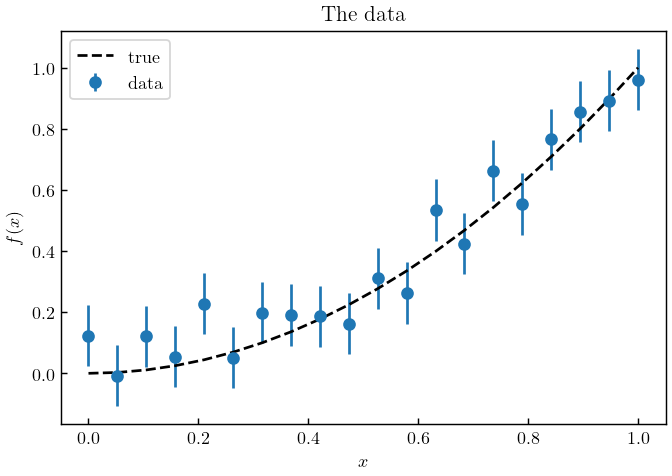

In [6]:
plt.plot(x, f(x), c='k', ls='--', label='true')
plt.errorbar(x, y, std, ls='', marker='o', label='data')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title("The data")
plt.legend();

To use a GP, we need to convert the 1d `x` input into an `NxD` matrix (since GPs can live in a `D` dimensional space, in general).
This is a `D=1` dimensional space in this example.

In [7]:
X = x[:, None]
X_star = x_star[:, None]

Begin by creating the kernel, which quantifies the correlation structure (smoothness properties) of the curves.
Then feed the kernel into a GP object, and fit it to the data we plotted above.
The radial basis function kernel (i.e., the Squared Exponential) has two hyperparameters that it depends on: the marginal variance and length scale.
Let's let the data decide which hyperparameters provide the best fit, via optimization.

In [8]:
# rbf_kernel = gptools.SquaredExponentialKernel(initial_params=[1,1], fixed_params=[True, True])
rbf_kernel = gptools.SquaredExponentialKernel(initial_params=[1.,1.], param_bounds=[(1e-9, 2), (1e-9, 2)])
gp = gptools.GaussianProcess(rbf_kernel)
gp.add_data(X, y, err_y=std)
gp.optimize_hyperparameters(max_tries=10)

(     fun: 24.41447538022654
      jac: array([ 0.00313854, -0.00214148])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 10
     njev: 10
   status: 0
  success: True
        x: array([0.74995056, 0.70354303]), 12)

That's it! Now we can get the curve of best fit and its uncertainty.

In [9]:
y_star, std_star = gp.predict(X_star, return_std=True)

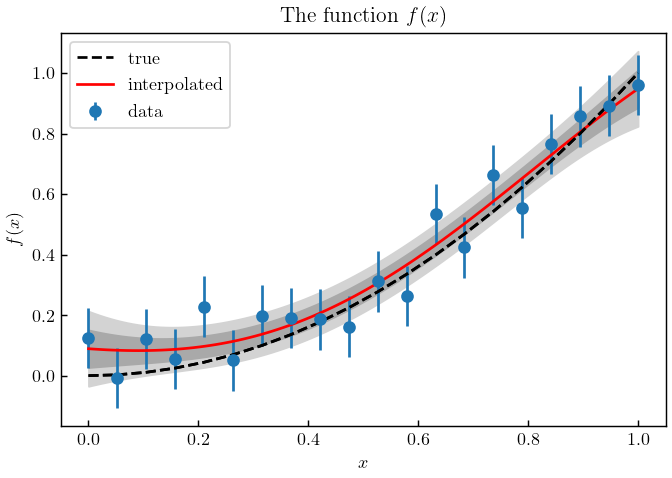

In [10]:
# set up figure
fig, ax = plt.subplots(1, 1)

# plot the data
plt.plot(x, f(x), c='k', ls='--', label='true')
plt.errorbar(x, y, std, ls='', marker='o', label='data')

# plot GP
y_star, std_star = gp.predict(X_star, return_std=True)
curve_plus_bands_plot(ax, x_star, y_star, std_star, c='r', label='interpolated')

# plot the function
plt.plot(x, f(x), c='k', ls='--')

# labels
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title("The function $f(x)$")
plt.legend();

### Estimating the derivative f'(x)

Since our function is simple, we can take its derivative analytically (e.g., using SymPy) and compare to our approximation. `GPTools` allows for predicting derivatives very easily! Just use `n=1` in the `predict` method to compute the first derivative.

In [11]:
derivOrder = 1 # order of the derivative
y_prime_star, std_prime_star = gp.predict(X_star, n=derivOrder, return_std=True)

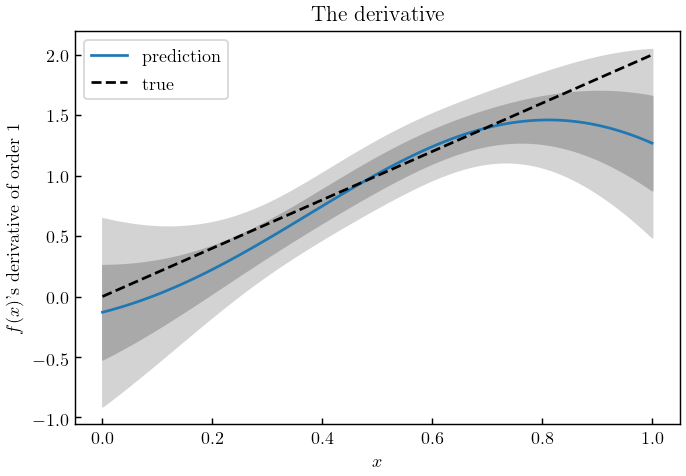

In [12]:
fig, ax = plt.subplots(1, 1)
curve_plus_bands_plot(ax, x_star, y_prime_star, std_prime_star, label="prediction")
plt.plot(x, f(x, derivOrder), c='k', ls='--', label="true")

plt.title("The derivative")
plt.xlabel('$x$');
plt.ylabel(f"$f(x)$'s derivative of order {derivOrder}")
plt.legend();

In [13]:
def draw_func_and_derivative(Xstar, kernel, X=None, y=None, err_y=None, draws=1, extra_kernel=None):
    n = Xstar.shape[0]
    XsXs = np.concatenate((Xstar, Xstar), axis=0)
    derivs = np.concatenate((np.zeros(Xstar.shape), np.ones(Xstar.shape)), axis=0)

    gp = gptools.GaussianProcess(k=kernel)
    if X is not None and y is not None:
        gp.add_data(X, y, err_y=err_y)
        gp.optimize_hyperparameters(max_tries=10)
        mean, K = gp.predict(XsXs, n=derivs, return_cov=True)
    else:
        K = gp.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)
        mean = np.zeros(2*n)
        
    if extra_kernel is not None:  # We will use this for the truncation error later
        gp_extra = gptools.GaussianProcess(k=extra_kernel)
        K += gp_extra.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)

    # The draw_sample function is much more numerically stable than
    # just using stats.multivariate_normal
    # Since we pass mean and cov, the first arguments aren't used.
    samples = gp.draw_sample(XsXs, derivs, mean=mean, cov=K, num_samp=draws)  # shape = (2n, draws)
    return samples.reshape(2, n, draws)  # separate f and f_prime by first dimension

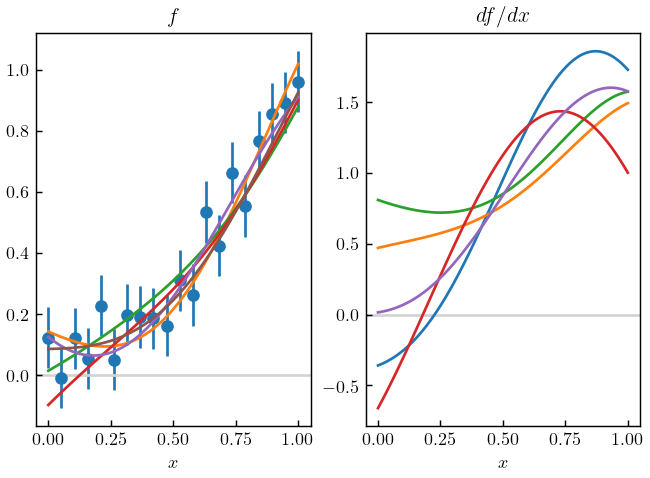

In [14]:
fig, [ax1, ax2] = plt.subplots(1, 2)

rbf_kernel_short = gptools.SquaredExponentialKernel(initial_params=[1, 0.25], param_bounds=[(1e-9, 2), (1e-9, 2)])

x_pred = np.linspace(0, 1, 100)


# Draw samples from fitted GP:

f_draw, fp_draw = draw_func_and_derivative(
    x_pred[:, None], rbf_kernel_short, X=X, y=y, err_y=std, draws=5)
ax1.errorbar(x, y, std, ls='', marker='o', label='data', zorder=0)


# Draw samples from unfitted GP:

# f_draw, fp_draw = draw_func_and_derivative(
#     x_pred[:, None], rbf_kernel_short, draws=5)


ax1.plot(x_pred, f_draw)
ax2.plot(x_pred, fp_draw)
ax1.set_title('$f$')
ax2.set_title('$df/dx$')
ax1.set_xlabel('$x$')
ax2.set_xlabel('$x$')
ax1.axhline(0, 0, 1, c='lightgrey', zorder=0)
ax2.axhline(0, 0, 1, c='lightgrey', zorder=0);

# Nuclear Matter Application

Our specific use case is similar to the example above: we fit a GP to data, in this case from a physics simulation.
But there is one additional source of uncertainty from the theory error. This will also involve us creating our own custom GP kernel!

Start again by getting some data.

In [15]:
df = pd.read_csv('../data/all_matter_data.csv')
# Convert differences to total prediction at each MBPT order
mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)
# 'total' is now unnecessary. Remove it.
df.pop('total');

In [16]:
orders = np.array([0, 2, 3, 4])
# body = 'NN-only'
body = 'NN+3N'
Lambda = 450
fits = {450: [1, 7], 500: [4, 10]}
train1 = slice(None, None, 5)
valid1 = slice(2, None, 5)
# valid1 = np.array([i % 5 != 0 for i in range(len())])
[fit_n2lo, fit_n3lo] = fits[Lambda]

excluded = np.array([1])

savefigs = False

mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])

mask1 = \
    (df['Body'] == body) & \
    mask_fit & \
    (df['Lambda'] == Lambda)


# df_fit = df[mask_fit]
df_n = df[mask1 & (df['x'] == 0)] 
df_s = df[mask1 & (df['x'] == 0.5)] 

kf_n = df_n[df_n['OrderEFT'] == 'LO']['kf'].values # Fermi momentum in neutron matter
kf_s = df_s[df_s['OrderEFT'] == 'LO']['kf'].values # Fermi momentum in symmetric matter
density = df_n[df_n['OrderEFT'] == 'LO']['n'].values # density
kf_d = kf_n.copy() # Fermi momentum associated with the symmetry energy

# valid1 = np.arange(len(kf_n)) % 5 != 0

Kf_n = kf_n[:, None]
Kf_s = kf_s[:, None]
Kf_d = kf_d[:, None]

y_n = np.array([df_n[df_n['OrderEFT'] == order]['MBPT_4'].values for order in df_n['OrderEFT'].unique()]).T # E/N
y_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T # E/A
y_d = y_n - y_s # symmetry energy

Visualize the EOS.

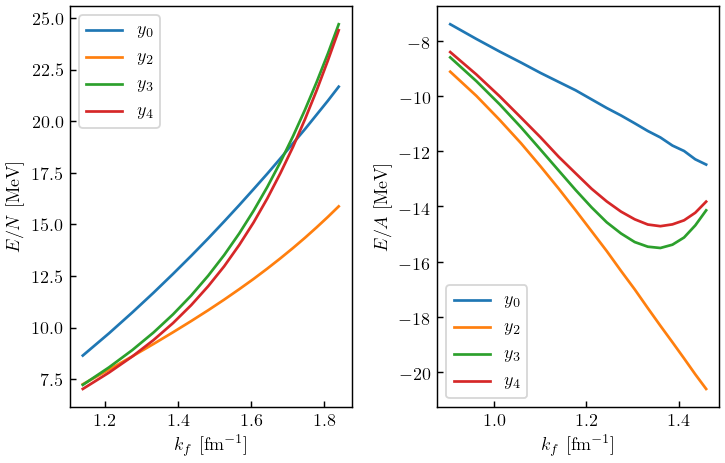

In [17]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout(pad=2.5) 

# first neutron matter
for i, n in enumerate(orders):
    ax[0].plot(kf_n, y_n[:, i], label=fr'$y_{n}$')
ax[0].legend()
ax[0].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[0].set_ylabel(r'$E/N$ [MeV]');

# then symmetric matter
for i, n in enumerate(orders):
    ax[1].plot(kf_s, y_s[:, i], label=fr'$y_{n}$')
ax[1].legend()
ax[1].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[1].set_ylabel(r'$E/A$ [MeV]');

The kernel for our GP convergence model is not a simple RBF, it must be multiplied by factors related to the converges of the EFT:

\begin{align}
    \kappa(x, x';\bar c, \ell) = y_{\text{ref}}(x)y_{\text{ref}}(x') \frac{[Q(x)Q(x')]^{k+1}}{1-Q(x)Q(x')} \bar c^2 r(x,x';\ell)
\end{align}

where $\bar c^2 r(x,x';\ell)$ is the RBF kernel used above.
GPTools can handle products of kernels, so we just need to create a kernel object that represents the prefactor above.
I'm still not completely sure how to make a truly compatible kernel object, but the code below seems to do the trick.

In [18]:
from gptools import ArbitraryKernel

In [19]:
class CustomKernel(gptools.Kernel):
    """A Custom GPTools kernel that wraps an arbitrary function f with a compatible signature
    
    Parameters
    ----------
    f : callable
        A positive semidefinite kernel function that takes f(Xi, Xj, ni, nj) where ni and nj are
        integers for the number of derivatives to take with respect to Xi or Xj. It should return
        an array of Xi.shape[0]
    *args
        Args passed to the Kernel class
    **kwargs
        Kwargs passed to the Kernel class
    """
    
    def __init__(self, f, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.f = f

    def __call__(self, Xi, Xj, ni, nj, hyper_deriv=None, symmetric=False):
#         return self.f(Xi, Xj, int(np.unique(ni)[0]), int(np.unique(nj)[0]))
        dmasks = {}
        coverage = np.zeros(ni.shape[0], dtype=bool)
        n_derivs = 2
        for i in range(n_derivs+1):
            for j in range(n_derivs+1):
                mask_ij = ((ni == i) & (nj == j)).ravel()
                dmasks[i, j] = mask_ij
                coverage = coverage | mask_ij

        if np.any(~coverage):
            raise ValueError(f'Only up to {n_derivs} derivatives per x allowed')
            
        value = np.NaN * np.ones(Xi.shape[0])
        for (i, j), mask in dmasks.items():
            value[mask] = self.f(Xi[mask], Xj[mask], i, j)
        return value
#         print(ni, nj, flush=True)
        # Only works for 1d X.
#         return np.array([
#             self.f(x_i, x_j, int(n_i[0]), int(n_j[0]))
#             for x_i, x_j, n_i, n_j in zip(Xi, Xj, ni, nj)
#         ])

We need to take arbitrary numbers of derivatives. Humans can make mistakes, let `SymPy` handle it.

In [20]:
from sympy import sqrt

def kernel_scale_sympy(lowest_order=4, highest_order=None):
    """Creates a sympy object that is the convergence part of the GP kernel
    
    Parameters
    ----------
    lowest_order
    highest_order
    """
    k_f1, k_f2, y_ref, Lambda_b, = symbols('k_f1 k_f2 y_ref Lambda_b')
    hbar_c = 197.3269718 # MeV fm
    Q1 = hbar_c * k_f1 / Lambda_b
    Q2 = hbar_c * k_f2 / Lambda_b
    num = (Q1 * Q2)**(lowest_order)
    if highest_order is not None:
        num = num - (Q1 * Q2)**highest_order
    kernel_scale = y_ref**2 * num / (1 - Q1*Q2)
    return k_f1, k_f2, Lambda_b, y_ref, kernel_scale

def eval_kernel_scale(Xi, Xj=None, ni=None, nj=None, breakdown=600, ref=16, lowest_order=4, highest_order=None):
    """Creates a matrix for the convergence part of the GP kernel.
    Compatible with the CustomKernel class signature.
    
    Parameters
    -----------
    Xi
    Xj
    ni
    nj
    breakdown
    ref
    lowest_order
    highest_order
    """
    if ni is None:
        ni = 0
    if nj is None:
        nj = 0
    k_f1, k_f2, Lambda_b, y_ref, kernel_scale = kernel_scale_sympy(
        lowest_order=lowest_order, highest_order=highest_order
    )
    expr = diff(kernel_scale, k_f1, ni, k_f2, nj)
    f = lambdify((k_f1, k_f2, Lambda_b, y_ref), expr, "numpy")
    if Xj is None:
        Xj = Xi
    K = f(Xi, Xj, breakdown, ref)
    K = K.astype('float')
    return np.squeeze(K)


class ConvergenceKernel:
    
    def __init__(self, breakdown=600, ref=16, lowest_order=4, highest_order=None):
        
        self.breakdown = breakdown
        self.ref = ref
        self.lowest_order = lowest_order
        self.highest_order = highest_order
        
        k_f1, k_f2, Lambda_b, y_ref, kernel_scale = kernel_scale_sympy(
            lowest_order=lowest_order, highest_order=highest_order
        )
        self.k_f1 = k_f1
        self.k_f2 = k_f2
        self.Lambda_b = Lambda_b
        self.y_ref = y_ref
        self.kernel_scale = kernel_scale
        
        self.ni_symbol, self.nj_symbol = symbols('n_i, n_j')
        
    def __call__(self, Xi, Xj=None, ni=None, nj=None):
        if ni is None:
            ni = 0
        if nj is None:
            nj = 0
#         k_f1, k_f2, Lambda_b, y_ref, kernel_scale = kernel_scale_sympy(
#             lowest_order=lowest_order, highest_order=highest_order
#         )
        k_f1 = self.k_f1
        k_f2 = self.k_f2
        Lambda_b = self.Lambda_b
        y_ref = self.y_ref
        kernel_scale = self.kernel_scale
        ni_symbol = self.ni_symbol
        nj_symbol = self.nj_symbol

        expr = diff(kernel_scale, k_f1, ni, k_f2, nj)
#         expr = diff(kernel_scale, (k_f1, ni_symbol), (k_f2, nj_symbol))
        f = lambdify((k_f1, k_f2, Lambda_b, y_ref), expr, "numpy")
        if Xj is None:
            Xj = Xi
            
        breakdown = self.breakdown
        ref = self.ref
        K = f(Xi, Xj, breakdown, ref)
#         K = f(Xi, Xj, breakdown, ref, ni, nj)
        try:
            K = K.astype('float')
        except:
            pass
        return np.squeeze(K)

Finally, we can create the kernel objects for our GP interpolation and derivatives. Assume some values for the hyperparameters, these would come from our convergence analysis of the observable coefficients.

In [21]:
from functools import partial

k_max = 4
# eval_kernel_lower = partial(eval_kernel_scale, lowest_order=0, highest_order=k_max)
# eval_kernel_upper = partial(eval_kernel_scale, lowest_order=k_max+1)
eval_kernel_lower = ConvergenceKernel(lowest_order=0, highest_order=k_max)
eval_kernel_upper = ConvergenceKernel(lowest_order=k_max+1)

matter_rbf_kernel_n = gptools.SquaredExponentialKernel(
    initial_params=[1,1], fixed_params=[True, True])
matter_rbf_kernel_s = gptools.SquaredExponentialKernel(
    initial_params=[1,1], fixed_params=[True, True])
matter_rbf_kernel_d = gptools.SquaredExponentialKernel(
    initial_params=[1,1], fixed_params=[True, True])

kernel_lower_n = CustomKernel(eval_kernel_lower) * matter_rbf_kernel_n
kernel_upper_n = CustomKernel(eval_kernel_upper) * matter_rbf_kernel_n

kernel_lower_s = CustomKernel(eval_kernel_lower) * matter_rbf_kernel_s
kernel_upper_s = CustomKernel(eval_kernel_upper) * matter_rbf_kernel_s

kernel_lower_d = CustomKernel(eval_kernel_lower) * matter_rbf_kernel_d
kernel_upper_d = CustomKernel(eval_kernel_upper) * matter_rbf_kernel_d


In [22]:
N_all = 50

#neutron matter
kf_n_all = np.linspace(kf_n[0], kf_n[-1], N_all)
Kf_n_all = kf_n_all[:, None]

#symmetric matter
kf_s_all = np.linspace(kf_s[0], kf_s[-1], N_all)
Kf_s_all = kf_s_all[:, None]

#symmetry energy
kf_d_all = np.linspace(kf_d[0], kf_d[-1], N_all)
Kf_d_all = kf_d_all[:, None]

#incompressibility
# kf_k_all = kf_s_all
# Kf_k_all = Kf_s_all

Begin by interpolating the data points we plotted above. This does not include truncation error yet. Also compute its derivative as before.

In [23]:
#neutron matter
gp_n_lower = gptools.GaussianProcess(kernel_lower_n)
gp_n_lower.add_data(Kf_n, y_n[:,-1], err_y=1e-5)

y_n_star, std_n_star = gp_n_lower.predict(Kf_n_all, return_std=True)
y_n_star_prime, std_n_star_prime = gp_n_lower.predict(Kf_n_all, n=1, return_std=True)

#symmetric matter
gp_s_lower = gptools.GaussianProcess(kernel_lower_s)
gp_s_lower.add_data(Kf_s, y_s[:,-1], err_y=1e-5)

y_s_star, std_s_star = gp_s_lower.predict(Kf_s_all, return_std=True)
y_s_star_prime, std_s_star_prime = gp_s_lower.predict(Kf_s_all, n=1, return_std=True)
# For incompressibility
y_s_star_prime2, std_s_star_prime2 = gp_s_lower.predict(Kf_s_all, n=2, return_std=True)

# We also need to covariance between y_s' and y_s''
Kf_s_all_twice = np.concatenate((Kf_s_all, Kf_s_all))
incomp_derivs_nums = np.concatenate((np.ones(N_all), 2*np.ones(N_all)))
pred_s_star_prime_prime2, cov_s_star_prime_prime2 = gp_s_lower.predict(
    Kf_s_all_twice, n=incomp_derivs_nums, return_cov=True, )

#symmetry energy
gp_d_lower = gptools.GaussianProcess(kernel_lower_d)
gp_d_lower.add_data(Kf_d, y_d[:,-1], err_y=1e-5)

y_d_star, std_d_star = gp_d_lower.predict(Kf_d_all, return_std=True)
y_d_star_prime, std_d_star_prime = gp_d_lower.predict(Kf_d_all, n=1, return_std=True)

# #incompressibility
# gp_k_lower = gptools.GaussianProcess(kernel_lower)
# gp_k_lower.add_data(Kf_s[:], y_s[:,-1], err_y=1e-5)

# y_k_star, std_k_star = gp_k_lower.predict(Kf_k_all, return_std=True)
# y_k_star_prime, std_k_star_prime = gp_k_lower.predict(Kf_k_all, n=2, return_std=True)

In [24]:
cov_s_star_prime_prime2.shape

(100, 100)

In [25]:
# Probably don't take sqrt because I think it can be negative
var_s_star_cov_prime_prime2 = np.diag(cov_s_star_prime_prime2[N_all:, :N_all])

In [26]:
np.allclose(np.concatenate((y_s_star_prime, y_s_star_prime2)), pred_s_star_prime_prime2)

True

But now we can create the additional source of uncertainty due to EFT truncation.
Create both the error term for the interpolant and for its derivative.

In [29]:
gp_n_upper = gptools.GaussianProcess(kernel_upper_n)
gp_s_upper = gptools.GaussianProcess(kernel_upper_s)
gp_d_upper = gptools.GaussianProcess(kernel_upper_d)

#neutron matter
zero_n_d = np.zeros(Kf_n_all.shape, dtype=int)
one_n_d = np.ones(Kf_n_all.shape, dtype=int)
var_n_upper_star = kernel_upper_n(Kf_n_all, Kf_n_all, ni=zero_n_d, nj=zero_n_d)
var_n_upper_star_prime = kernel_upper_n(Kf_n_all, Kf_n_all, ni=one_n_d, nj=one_n_d)
# gp_n_upper.compute_Kij(Kf_n_all, ni=0, nj=0)

std_n_total_star = np.sqrt(std_n_star**2 + var_n_upper_star)
std_n_total_star_prime = np.sqrt(std_n_star_prime**2 + var_n_upper_star_prime)

#symmetric matter
zero_s_d = np.zeros(Kf_s_all.shape, dtype=int)
one_s_d = np.ones(Kf_s_all.shape, dtype=int)
var_s_upper_star = kernel_upper_s(Kf_s_all, Kf_s_all, ni=zero_s_d, nj=zero_s_d)
var_s_upper_star_prime = kernel_upper_s(Kf_s_all, Kf_s_all, ni=one_s_d, nj=one_s_d)
var_s_upper_star_prime2 = kernel_upper_s(Kf_s_all, Kf_s_all, ni=2*one_s_d, nj=2*one_s_d)
var_s_upper_star_cov_prime_prime2 = kernel_upper_s(Kf_s_all, Kf_s_all, ni=one_s_d, nj=2*one_s_d)

std_s_total_star = np.sqrt(std_s_star**2 + var_s_upper_star)
std_s_total_star_prime = np.sqrt(std_s_star_prime**2 + var_s_upper_star_prime)
std_s_total_star_prime2 = np.sqrt(std_s_star_prime2**2 + var_s_upper_star_prime2)
var_s_total_star_cov_prime_prime2 = var_s_star_cov_prime_prime2 + var_s_upper_star_cov_prime_prime2

#symmetry energy
zero_d_d = np.zeros(Kf_d_all.shape, dtype=int)
one_d_d = np.ones(Kf_d_all.shape, dtype=int)
var_d_upper_star = kernel_upper_d(Kf_d_all, Kf_d_all, ni=zero_d_d, nj=zero_d_d)
var_d_upper_star_prime = kernel_upper_d(Kf_d_all, Kf_d_all, ni=one_d_d, nj=one_d_d)

std_d_total_star = np.sqrt(std_d_star**2 + var_d_upper_star)
std_d_total_star_prime = np.sqrt(std_d_star_prime**2 + var_d_upper_star_prime)

#incompressibility
# zero_k_d = np.zeros(Kf_k_all.shape, dtype=int)
# one_k_d = np.ones(Kf_k_all.shape, dtype=int)
# std_k_upper_star = np.sqrt(kernel_upper(Kf_k_all, Kf_k_all, ni=zero_k_d, nj=zero_k_d))
# std_k_upper_star_prime = np.sqrt(kernel_upper(Kf_k_all, Kf_k_all, ni=one_k_d, nj=one_k_d))
# std_k_upper_star_prime2 = np.sqrt(kernel_upper(Kf_k_all, Kf_k_all, ni=2*one_k_d, nj=2*one_k_d))

# std_k_total_star = std_k_star + std_k_upper_star
# std_k_total_star_prime = std_k_star_prime + std_k_upper_star_prime 

Let's see how we did. The light grey error bands represent 2 standard deviations.
The left plot shows the interpolant alone, with error bands that are so small they can't be seen.
The right plot is the same as the left, except truncation bands are added.

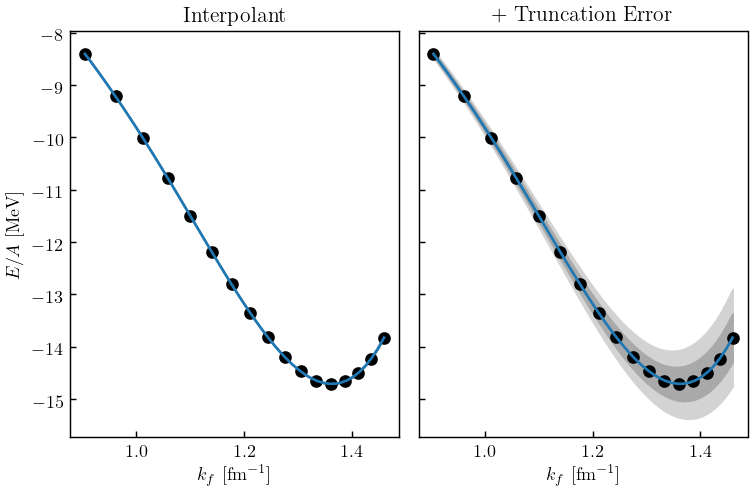

In [30]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
ax1, ax2 = axes
ax1.plot(kf_s, y_s[:, -1], ls='', marker='o', c='k');
curve_plus_bands_plot(ax1, kf_s_all, y_s_star, std_s_star)
ax1.set_title('Interpolant')
ax1.set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax1.set_ylabel(r'$E/A$ [MeV]')

ax2.plot(kf_s, y_s[:, -1], ls='', marker='o', c='k');
curve_plus_bands_plot(ax2, kf_s_all, y_s_star, std_s_total_star)
ax2.set_title('+ Truncation Error')
ax2.set_xlabel(r'$k_f$ [fm$^{-1}$]')
fig.tight_layout()

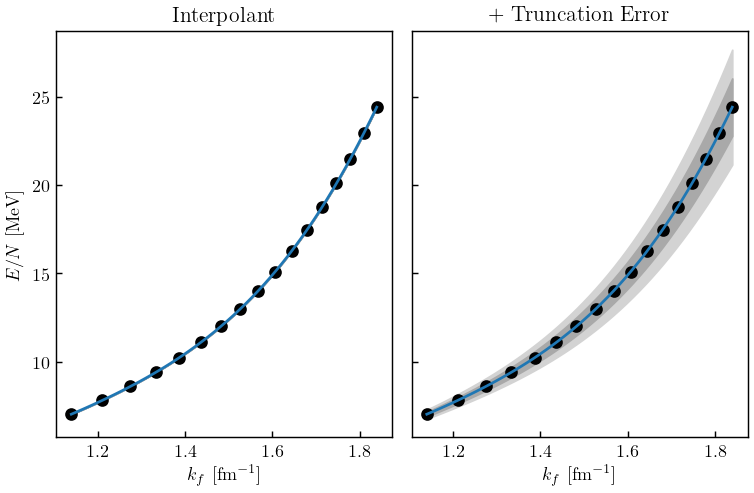

In [31]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
ax1, ax2 = axes
ax1.plot(kf_n, y_n[:, -1], ls='', marker='o', c='k');
curve_plus_bands_plot(ax1, kf_n_all, y_n_star, std_n_star)
ax1.set_title('Interpolant')
ax1.set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax1.set_ylabel(r'$E/N$ [MeV]')

ax2.plot(kf_n, y_n[:, -1], ls='', marker='o', c='k');
curve_plus_bands_plot(ax2, kf_n_all, y_n_star, std_n_total_star)
ax2.set_title('+ Truncation Error')
ax2.set_xlabel(r'$k_f$ [fm$^{-1}$]')
fig.tight_layout()

In [40]:
def highlight_nsat(ax,nsat=0.16):
    ax.axvline(nsat, ls=":", c=color_95, zorder=0)

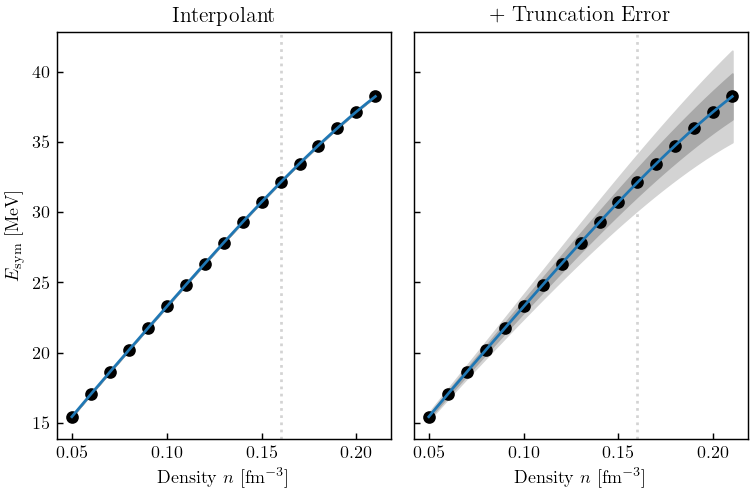

In [44]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
ax1, ax2 = axes

ax1.plot(density, y_d[:, -1], ls='', marker='o', c='k');
curve_plus_bands_plot(ax1, density_all, y_d_star, std_d_star)
ax1.set_title('Interpolant')
# ax1.set_xlabel(r'$k_f$ [fm$^{-1}$]')
highlight_nsat(ax1)
ax1.set_xlabel(r"Density $n$ [fm$^{-3}$]")
ax1.set_ylabel(r'$E_\mathrm{sym}$ [MeV]')

ax2.plot(density, y_d[:, -1], ls='', marker='o', c='k');
curve_plus_bands_plot(ax2, density_all, y_d_star, std_d_total_star)
ax2.set_title('+ Truncation Error')
# ax2.set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax2.set_xlabel(r"Density $n$ [fm$^{-3}$]")
highlight_nsat(ax2)
fig.tight_layout()

Plot the derivatives with respect to $k_{f}$ similarly

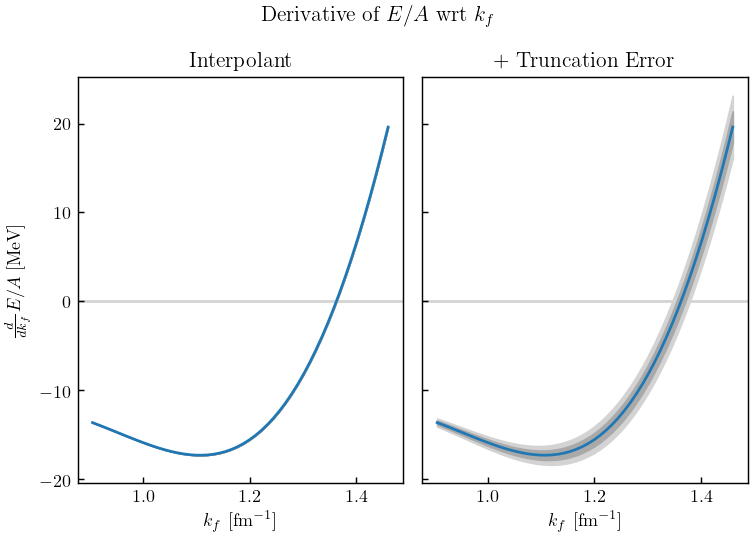

In [33]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
ax1, ax2 = axes

curve_plus_bands_plot(ax1, kf_s_all, y_s_star_prime, std_s_star_prime)
ax1.axhline(0, 0, 1, c=color_95, zorder=0)
ax1.set_title('Interpolant')
ax1.set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax1.set_ylabel(r"$\frac{d}{dk_f} E/A$ [MeV]")

curve_plus_bands_plot(ax2, kf_s_all, y_s_star_prime, std_s_total_star_prime)
ax2.axhline(0, 0, 1, c=color_95, zorder=0)
ax2.set_title('+ Truncation Error')
ax2.set_xlabel(r'$k_f$ [fm$^{-1}$]')

fig.suptitle('Derivative of $E/A$ wrt $k_{f}$', y=1.05)
fig.tight_layout()

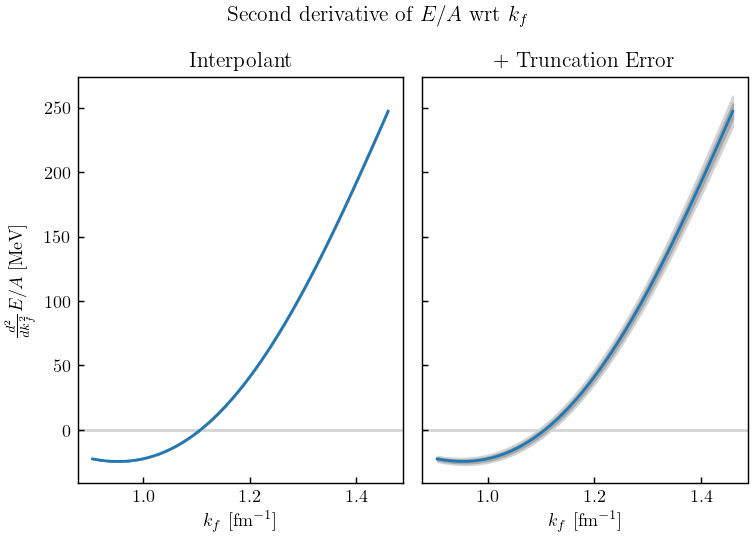

In [34]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
ax1, ax2 = axes

curve_plus_bands_plot(ax1, kf_s_all, y_s_star_prime2, std_s_star_prime2)
ax1.axhline(0, 0, 1, c=color_95, zorder=0)
ax1.set_title('Interpolant')
ax1.set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax1.set_ylabel(r"$\frac{d^2}{dk_f^2} E/A$ [MeV]")

curve_plus_bands_plot(ax2, kf_s_all, y_s_star_prime2, std_s_total_star_prime2)
ax2.axhline(0, 0, 1, c=color_95, zorder=0)
ax2.set_title('+ Truncation Error')
ax2.set_xlabel(r'$k_f$ [fm$^{-1}$]')

fig.suptitle('Second derivative of $E/A$ wrt $k_{f}$', y=1.05)
fig.tight_layout()

In [35]:
# fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
# ax1, ax2 = axes

# curve_plus_bands_plot(ax1, kf_k_all, y_k_star_prime, std_k_star_prime)
# ax1.axhline(0, 0, 1, c=color_95, zorder=0)
# ax1.set_title('Interpolant')
# ax1.set_xlabel(r'$k_f$ [fm$^{-1}$]')
# ax1.set_ylabel(r"$\frac{d^2}{dk_f^2} E/A$ [MeV]")

# curve_plus_bands_plot(ax2, kf_k_all, y_k_star_prime, std_k_total_star_prime)
# ax2.axhline(0, 0, 1, c=color_95, zorder=0)
# ax2.set_title('+ Truncation Error')
# ax2.set_xlabel(r'$k_f$ [fm$^{-1}$]')

# fig.suptitle('Second derivative of $E/A$ wrt $k_{f}$', y=1.05)
# fig.tight_layout()

Nice! This is, up to some easily handled scaling factors, the pressure $P$! With truncation errors! We find
$$ 
P = n^2 \frac{d}{dn} \frac{E}{A} = n^2 \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A} = n^2 \frac{k_f}{3n} \frac{d}{dk_f}  \frac{E}{A} = n \frac{k_f}{3} \frac{d}{dk_f}  \frac{E}{A}
$$
where $k_f = \sqrt[3]{3\pi^2\, n/2}$ ($k_f = \sqrt[3]{3\pi^2\, n}$) for symmetric (neutron) matter.

It is useful to note that
\begin{align}
    \frac{dk}{dn} & = \frac{k}{3n} \\
    \frac{d^2k}{dn^2} & = -\frac{2k}{9n^2}
\end{align}

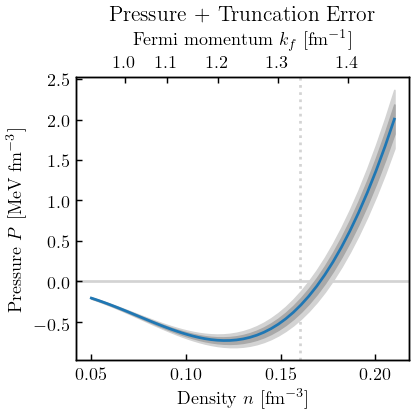

In [37]:
density_all = nuclear_density(kf_s_all, degeneracy=4)
to_pressure_factor = kf_s_all / 3 * density_all

pressure = y_s_star_prime * to_pressure_factor
pressure_std = std_s_total_star_prime * to_pressure_factor

fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax2 = ax.twiny() # axis for kf
curve_plus_bands_plot(ax, density_all, pressure, pressure_std)
ax.axhline(0, 0, 1, c=color_95, zorder=0)
highlight_nsat(ax)

# set labels and title
ax.set_xlabel(r"Density $n$ [fm$^{-3}$]")
ax.set_ylabel(r'Pressure $P$ [MeV fm$^{-3}$]')
ax2.set_xlabel(r'Fermi momentum $k_f$ [fm$^{-1}$]')
ax.set_title('Pressure + Truncation Error')

# set limits and ticks for kf axis
kfTickLocations = np.array([1.0, 1.1, 1.2, 1.3, 1.4])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(nuclear_density(kfTickLocations,4))
ax2.set_xticklabels(kfTickLocations)

fig.tight_layout();

$$
L(n) = 3\,n \, \frac{d}{dn} E_\text{sym}(n) = \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A}(n) 
     = 3\,n \, \frac{k_f}{3n} \frac{d}{dk_f}  E_\text{sym}(n) = k_f \frac{d}{dk_f} E_\text{sym}(n)
$$

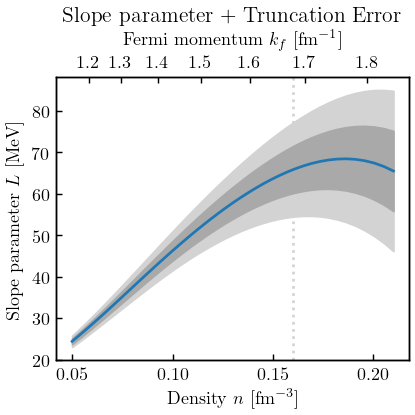

In [38]:
density_all = nuclear_density(kf_d_all, degeneracy=2)
to_Lparam_factor = kf_d_all

Lparam = y_d_star_prime * to_Lparam_factor
Lparam_std = std_d_total_star_prime * to_Lparam_factor

fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax2 = ax.twiny() # axis for kf
curve_plus_bands_plot(ax, density_all, Lparam, Lparam_std)
highlight_nsat(ax)

# set labels and title
ax.set_xlabel(r"Density $n$ [fm$^{-3}$]")
ax.set_ylabel(r'Slope parameter $L$ [MeV]')
ax2.set_xlabel(r'Fermi momentum $k_f$ [fm$^{-1}$]')
ax.set_title('Slope parameter + Truncation Error')

# set limits and ticks for kf axis
kfTickLocations = np.array([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(nuclear_density(kfTickLocations,2))
ax2.set_xticklabels(kfTickLocations)

fig.tight_layout();

In [85]:
def confidence_ellipse(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

#     cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

#     # Calculating the stdandard deviation of x from
#     # the squareroot of the variance and multiplying
#     # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
#     mean_x = np.mean(x)

#     # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
#     mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [90]:

density_sat = np.array([0.16, 0.16])
Kf_n_sat = fermi_momentum(density_sat, 2)[:, None]
Kf_s_sat = fermi_momentum(density_sat, 4)[:, None]
# Kf_d_sat = (Kf_n_sat + Kf_s_sat) / 2.
Kf_d_sat = Kf_n_sat
Esym_L_sat_derivs = np.array([[0], [1]])
y_d_sat, cov_d_sat_lower = gp_d_lower.predict(Kf_d_sat, n=Esym_L_sat_derivs, return_cov=True)

# cov_d_sat_upper = kernel_upper_d(Kf_d_sat, Kf_d_sat, ni=Esym_L_sat_derivs, nj=Esym_L_sat_derivs)
cov_d_sat_upper = gp_d_upper.compute_Kij(Kf_d_sat, Kf_d_sat, ni=Esym_L_sat_derivs, nj=Esym_L_sat_derivs)

to_Esym_L_mat = np.array([
    [1, 0],
    [0, Kf_d_sat[0,0]]
])

Esym_L_sat = to_Esym_L_mat @ y_d_sat
cov_Esym_L = to_Esym_L_mat @ (cov_d_sat_upper + cov_d_sat_lower) @ to_Esym_L_mat.T
# mvn_d_sat = stats.multivariate_normal(mean=y_d_sat, cov=cov_Esym_L)
# Esym_L_samples = mvn_d_sat.rvs(100)
# plt.scatter(*Esym_L_samples.T)


In [91]:
cov_d_sat_upper

array([[ 0.97379612,  3.15362426],
       [ 3.15362426, 11.4048756 ]])

In [92]:
np.linalg.det(cov_Esym_L)

3.273951921124125

In [93]:
np.linalg.eigh(cov_Esym_L)

(array([ 0.09907637, 33.04473066]), array([[-0.9866355 ,  0.16294288],
        [ 0.16294288,  0.9866355 ]]))

In [94]:
cov_Esym_L

array([[ 0.97379613,  5.29651584],
       [ 5.29651584, 32.1700109 ]])

In [95]:
y_d_sat

array([32.12073106, 39.21625366])

In [96]:
Esym_L_sat

array([32.12073106, 65.86374647])

(0, 100)

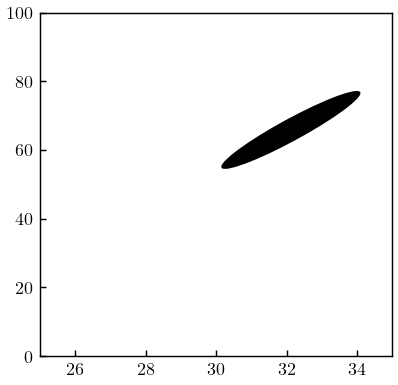

In [98]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
confidence_ellipse(Esym_L_sat, cov_Esym_L, ax=ax, n_std=2, facecolor='k')
ax.set_xlim(25, 35)
ax.set_ylim(0, 100)

In [48]:
y_d_sat

array([-1041.93032625, -3468.28394095])

In [46]:
Esym_L_samples.shape

(100, 2)

<!-- $$ 
K(n) = 9 \, n^2 \frac{d}{dn} \frac{E}{A} = 9 \, n^2 \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A} = 9 \, n^2 \frac{k_f}{3n} \frac{d}{dk_f}  \frac{E}{A} = 3 \, n \, k_f \frac{d}{dk_f}  \frac{E}{A}
$$ -->

\begin{align}
    K(n) = 9 n^2 \frac{d^2}{dn^2} \frac{E}{A} = 9 n^2 \left[\frac{d^2k_f}{dn^2} \left(\frac{d}{dk_f} \frac{E}{A}\right) + \left(\frac{dk_f}{dn}\right)^2 \frac{d^2}{dk_f^2} \frac{E}{A} \right]
\end{align}

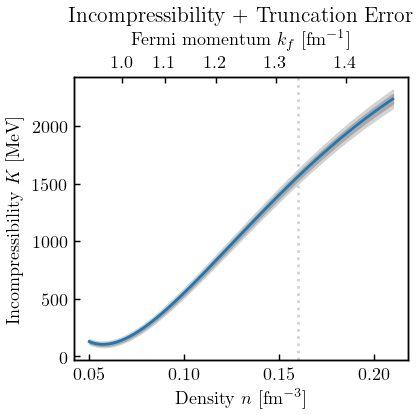

In [39]:
density_all = nuclear_density(kf_s_all, degeneracy=4)
to_incomp_factor = kf_s_all * 3 * density_all

d2kf_s_dn2 = -2 * kf_s_all / (9 * density_all**2)
dkf_s_dn = kf_s_all / (3 * density_all)

# incomp = y_s_star_prime * to_incomp_factor
# incomp_std = std_s_total_star_prime * to_incomp_factor
incomp = 9 * density_all * (d2kf_s_dn2 * y_s_star_prime + dkf_s_dn**2 * y_s_star_prime2)
incomp_std = 9 * density_all * np.sqrt(
    (d2kf_s_dn2 * std_s_total_star_prime)**2 + (dkf_s_dn**2 * std_s_total_star_prime2)**2 +
    2 * d2kf_s_dn2 * dkf_s_dn**2 * var_s_total_star_cov_prime_prime2
)

fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax2 = ax.twiny() # axis for kf
curve_plus_bands_plot(ax, density_all, incomp, incomp_std)
highlight_nsat(ax)

# set labels and title
ax.set_xlabel(r"Density $n$ [fm$^{-3}$]")
ax.set_ylabel(r'Incompressibility $K$ [MeV]')
ax2.set_xlabel(r'Fermi momentum $k_f$ [fm$^{-1}$]')
ax.set_title('Incompressibility + Truncation Error')

# set limits and ticks for kf axis
kfTickLocations = np.array([1.0, 1.1, 1.2, 1.3, 1.4])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(nuclear_density(kfTickLocations,4))
ax2.set_xticklabels(kfTickLocations)

fig.tight_layout();